In [1]:
%load_ext autoreload
%autoreload 2

from circuit_breaking.src import *
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from circuit_breaking.src.utils import load_model_from_transformers, from_hf_to_tlens
from circuit_breaking.src.masks import MLPHiddenMask
from tqdm.auto import tqdm
#torch.autograd.set_detect_anomaly(True) 


In [2]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer
model_name_or_path = "google/gemma-7b"
model_type = "gemma"

tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

n_layers = 28
n_heads = 16

print(torch.cuda.memory_allocated() / 1024**3)

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


0.0


In [3]:
maintain_sport = None


forget_sport=None
forget_athletes = 16
save_dir = f"results/localized_finetuning_{forget_athletes}_athletes"
forget_kwargs = {"forget_player_subset": forget_athletes, "is_forget_dataset": True, "train_test_split": False}
maintain_kwargs = {"forget_player_subset": forget_athletes, "is_forget_dataset": False, "train_test_split": True}

# forget_sport="basketball"
# forget_athletes = None
# save_dir = f"results/localized_finetuning_{forget_sport}"
# forget_kwargs = {"forget_sport_subset": {forget_sport}, "is_forget_dataset": True, "train_test_split": True}
# maintain_kwargs = {"forget_sport_subset": {forget_sport}, "is_forget_dataset": False, "train_test_split": True}
# forget_loss_coef = .2


In [4]:
from cb_utils.mask_utils import convert_attrs_to_components, get_top_components, get_top_components_no_subcomponents, get_random_components, load_mask_from_state_dict, get_parameter, apply_localized_gradients

import pickle
with open("models/google_gemma-7b_sports_all_ap_graph.pkl", "rb") as f:
    ap_graph = pickle.load(f)
print(ap_graph.keys())

# ct components
with open("models/google_gemma-7b_sports_all_ct_graph.pkl", "rb") as f:
    ct_graph = pickle.load(f)
print(ct_graph)

beta = 3
top_p = 5
combine_heads = True

localization_types = ["localized_ap", "localized_ct", "random", "manual_interp", "nonlocalized"]
# localization_types = ["localized_ap", "localized_ct"]
# localization_types = ["manual_interp", "nonlocalized"]
# localization_types = ["manual_interp"]

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
color_map = {"localized_ap": colors[0], "localized_ct": colors[1], "random": colors[2], "manual_interp": colors[3], "nonlocalized": colors[4]}
formal_name_dict = {"localized_ap": "Localized AP", "localized_ct": "Localized CT", "random": "Random", "manual_interp": "Manual Interp", "nonlocalized": "Nonlocalized"}

from collections import defaultdict
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval_redo

# combine_heads = True
top_p = 5
learning_rate = 1e-5
n_epochs = 50
# max_gpu_batch_size=8
beta = 3

training_dict = {}

for localization_type in localization_types:
    with open(f"{save_dir}/models/{model_type}_{localization_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}_metrics.pkl", "rb") as f:
        training_dict[localization_type] = pickle.load(f)
        # pickle.dump({"train_losses": all_train_losses, "test_losses": all_test_losses, "adversarial_evals": adversarial_evals, "side_effect_evals": side_effect_evals}, f)

dict_keys(['a0.0_q', 'a0.1_q', 'a0.2_q', 'a0.3_q', 'a0.4_q', 'a0.5_q', 'a0.6_q', 'a0.7_q', 'a0.8_q', 'a0.9_q', 'a0.10_q', 'a0.11_q', 'a0.12_q', 'a0.13_q', 'a0.14_q', 'a0.15_q', 'a0.0_k', 'a0.1_k', 'a0.2_k', 'a0.3_k', 'a0.4_k', 'a0.5_k', 'a0.6_k', 'a0.7_k', 'a0.8_k', 'a0.9_k', 'a0.10_k', 'a0.11_k', 'a0.12_k', 'a0.13_k', 'a0.14_k', 'a0.15_k', 'a0.0_v', 'a0.1_v', 'a0.2_v', 'a0.3_v', 'a0.4_v', 'a0.5_v', 'a0.6_v', 'a0.7_v', 'a0.8_v', 'a0.9_v', 'a0.10_v', 'a0.11_v', 'a0.12_v', 'a0.13_v', 'a0.14_v', 'a0.15_v', 'a0.0_result', 'a0.1_result', 'a0.2_result', 'a0.3_result', 'a0.4_result', 'a0.5_result', 'a0.6_result', 'a0.7_result', 'a0.8_result', 'a0.9_result', 'a0.10_result', 'a0.11_result', 'a0.12_result', 'a0.13_result', 'a0.14_result', 'a0.15_result', 'a1.0_q', 'a1.1_q', 'a1.2_q', 'a1.3_q', 'a1.4_q', 'a1.5_q', 'a1.6_q', 'a1.7_q', 'a1.8_q', 'a1.9_q', 'a1.10_q', 'a1.11_q', 'a1.12_q', 'a1.13_q', 'a1.14_q', 'a1.15_q', 'a1.0_k', 'a1.1_k', 'a1.2_k', 'a1.3_k', 'a1.4_k', 'a1.5_k', 'a1.6_k', 'a1.7_k',

## Make Graphics of saved results

In [6]:
training_dict['localized_ap']['test_losses']['forget_sport']

[2.0859375,
 3.609375,
 7.2,
 10.65,
 12.5125,
 15.7875,
 17.825,
 17.55,
 17.125,
 16.8,
 17.05,
 17.375,
 17.65,
 17.875,
 17.975,
 18.025,
 18.0,
 17.575,
 17.45,
 17.225,
 17.425,
 17.075,
 16.95,
 16.8,
 16.7,
 16.55,
 16.8,
 16.8,
 16.5,
 16.825,
 16.8,
 16.65,
 16.825,
 16.825,
 17.175,
 16.95,
 17.05,
 16.7,
 16.85,
 16.975,
 16.925,
 16.85,
 17.075,
 17.025,
 17.05,
 16.95,
 16.825,
 17.0,
 16.9,
 16.95]

In [7]:
# retraining results
n_relearn_iters = 10
n_relearn_athletes = 2

with open(f"{save_dir}/results/relearning_{n_relearn_athletes=}_{n_relearn_iters=}_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}_results.pkl", "rb") as f:
    # pickle.dump({"relearning_regular_results": relearning_regular_results, "relearning_adversarial_results": relearning_adversarial_results, "relearning_side_effect_results": relearning_side_effect_results, "relearning_train_results": relearning_train_results, "relearning_test_results": relearning_test_results}, f)
    relearning_results = pickle.load(f)
    relearning_regular_results = relearning_results["relearning_regular_results"]
    relearning_adversarial_results = relearning_results["relearning_adversarial_results"]
    relearning_side_effect_results = relearning_results["relearning_side_effect_results"]
    relearning_train_results = relearning_results["relearning_train_results"]
    relearning_test_results = relearning_results["relearning_test_results"]

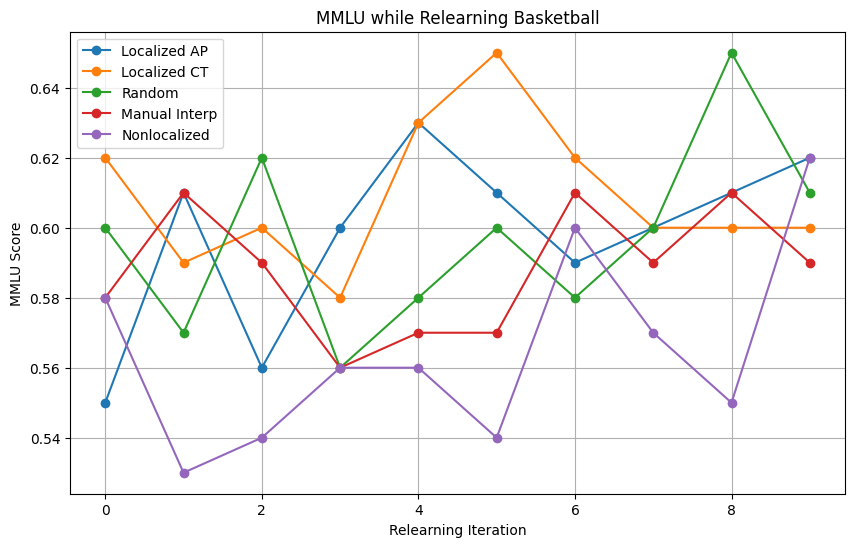

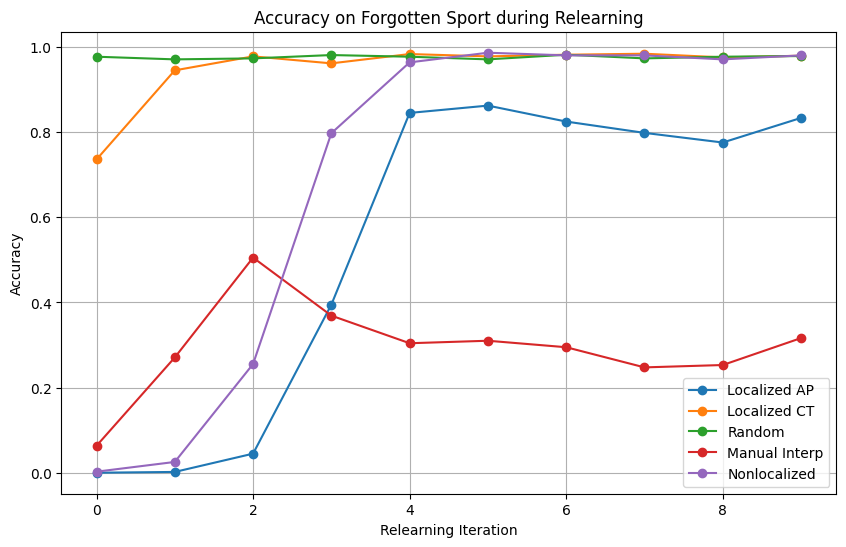

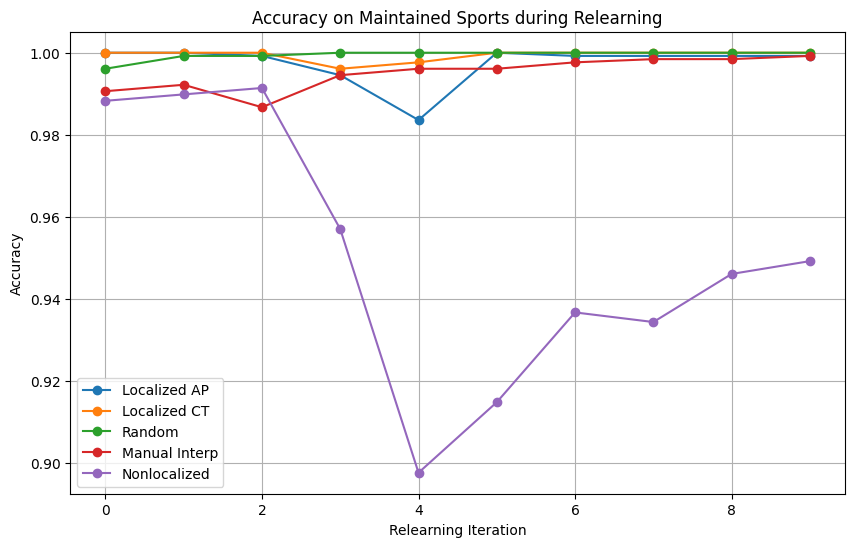

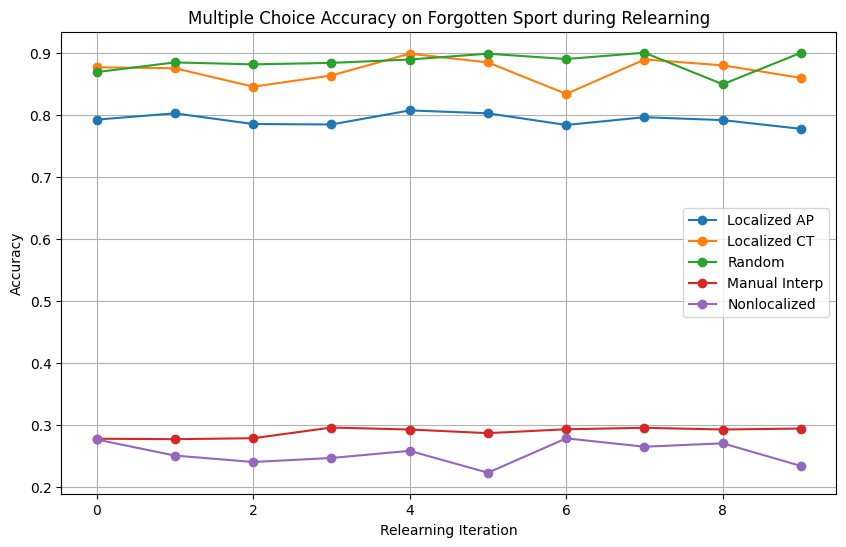

In [16]:
import matplotlib.pyplot as plt

# Function to plot relearning results
def plot_relearning_results(relearning_test_results, metric, title, ylabel, formal=True):
    plt.figure(figsize=(10, 6))
    for name, results in relearning_test_results.items():
        values = [result[metric] if metric != 'adversarial' else result[metric]['Normal']['forget'] for result in results]
        if formal:
            plt.plot(range(len(values)), values, label=formal_name_dict[name], marker='o', color=color_map[name])
        else:
            plt.plot(range(len(values)), values, label=name, marker='o')
    plt.xlabel('Relearning Iteration')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot MMLU
plot_relearning_results(relearning_test_results, 'MMLU', 'MMLU while Relearning Basketball', 'MMLU Score')

# Plot adversarial-normal-forget
def plot_adversarial_results(relearning_test_results, adversarial_type, forget_or_maintain, title, ylabel, formal=True):
    plt.figure(figsize=(10, 6))
    for name, results in relearning_test_results.items():
        values = [result['adversarial'][adversarial_type][forget_or_maintain] for result in results]
        # plt.plot(range(len(values)), values, label=name, marker='o')
        if formal:
            plt.plot(range(len(values)), values, label=formal_name_dict[name], marker='o', color=color_map[name])
        else:
            plt.plot(range(len(values)), values, label=name, marker='o')
    plt.xlabel('Relearning Iteration')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot adversarial-normal-forget
plot_adversarial_results(relearning_test_results, 'Normal', 'forget', 'Accuracy on Forgotten Sport during Relearning', 'Accuracy')

# Plot adversarial-normal-maintain
plot_adversarial_results(relearning_test_results, 'Normal', 'maintain', 'Accuracy on Maintained Sports during Relearning', 'Accuracy')

# Plot adversarial-mc-forget
plot_adversarial_results(relearning_test_results, 'MC', 'forget', 'Multiple Choice Accuracy on Forgotten Sport during Relearning', 'Accuracy')



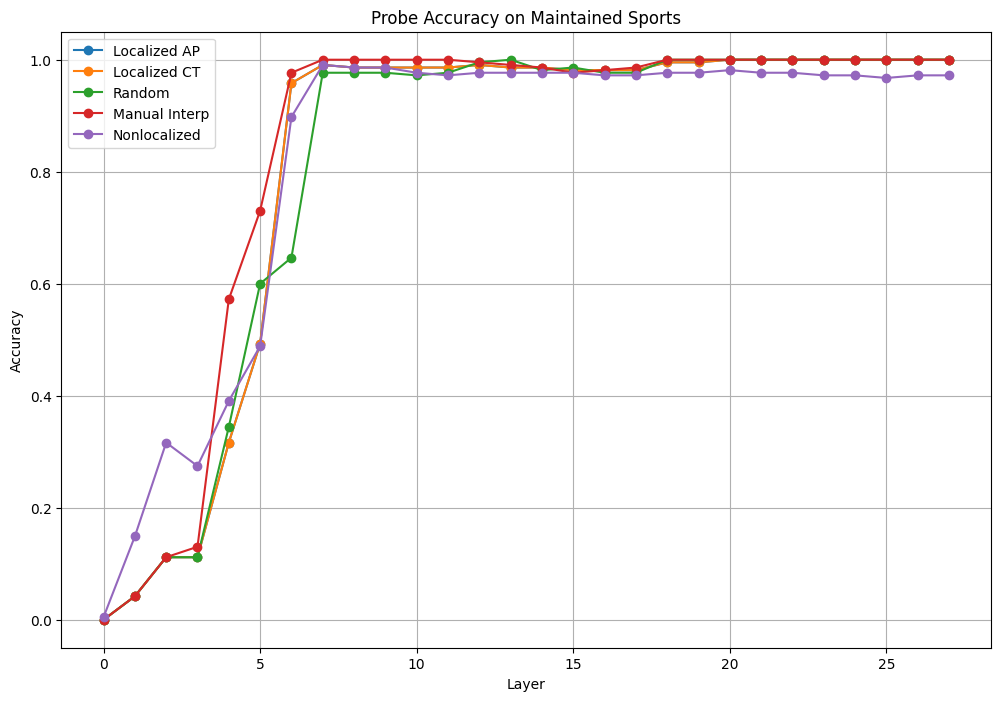

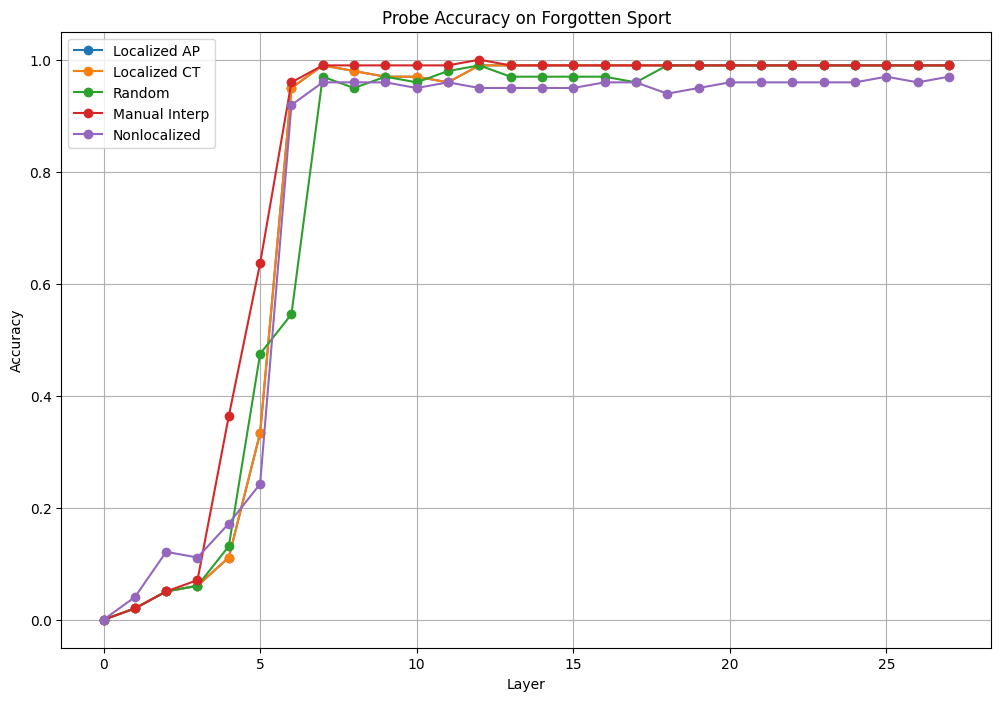

In [18]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
# combine_heads = False #accidentally set this earlier, but its not actually False in the models
with open(f"{save_dir}/results/probes_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pkl", "rb") as f:
    results = pickle.load(f)
    all_probes = results['all_probes']
    all_train_accs = results['all_train_accs']
    all_test_accs = results['all_test_accs']
    all_forget_accs = results['all_forget_accs']
    all_maintain_accs = results['all_maintain_accs']

combine_accuracies = True
# if combine_accuracies:
#     def plot_accuracies(all_train_accs, all_test_accs, all_forget_accs, all_maintain_accs):
#         for model_name in all_train_accs.keys():
#             layers = list(all_train_accs[model_name].keys())
#             train_accs = [all_train_accs[model_name][layer] for layer in layers]
#             test_accs = [all_test_accs[model_name][layer] for layer in layers]
#             forget_accs = [all_forget_accs[model_name][layer] for layer in layers]
#             maintain_accs = [all_maintain_accs[model_name][layer] for layer in layers]

#             plt.figure(figsize=(10, 6))
#             plt.plot(layers, train_accs, label='Train Accuracy', alpha=0.5, linestyle='--')
#             # plt.plot(layers, test_accs, label='Test Accuracy')
#             plt.plot(layers, forget_accs, label='Forget Accuracy')
#             plt.plot(layers, maintain_accs, label='Maintain Accuracy')
            
#             plt.xlabel('Layer')
#             plt.ylabel('Accuracy')
#             plt.title(f'Accuracy per Layer for {model_name}')
#             plt.legend()
#             plt.grid(True)
#             plt.show()

#     # Call the function to plot the accuracies
#     plot_accuracies(all_train_accs, all_test_accs, all_forget_accs, all_maintain_accs)

# else:
#     def plot_accuracies(all_train_accs, all_test_accs):
#         sports = ["baseball", "football", "basketball"]
        
#         for model_name in all_train_accs.keys():
#             layers = list(all_train_accs[model_name].keys())
            
#             plt.figure(figsize=(12, 8))
            
#             for sport in sports:
#                 train_accs = [all_train_accs[model_name][layer].get(sport, 0) for layer in layers]
#                 test_accs = [all_test_accs[model_name][layer].get(sport, 0) for layer in layers]
#                 # forget_accs = [all_forget_accs[model_name][layer].get(sport, 0) for layer in layers]
#                 # maintain_accs = [all_maintain_accs[model_name][layer].get(sport, 0) for layer in layers]
                
#                 plt.plot(layers, train_accs, label=f'Train Accuracy - {sport}', linestyle='--', alpha=0.5)
#                 plt.plot(layers, test_accs, label=f'Test Accuracy - {sport}')
#                 # plt.plot(layers, forget_accs, label=f'Forget Accuracy - {sport}')
#                 # plt.plot(layers, maintain_accs, label=f'Maintain Accuracy - {sport}')
            
#             plt.xlabel('Layer')
#             plt.ylabel('Accuracy')
#             plt.title(f'Accuracy per Layer for {model_name}')
#             plt.legend()
#             plt.grid(True)
#             plt.show()

#     # Call the function to plot the accuracies
#     plot_accuracies(all_train_accs, all_test_accs)
def plot_final_accuracies(all_accs, formal=True):
    # colors = plt.cm.get_cmap('tab10', len(all_train_accs))  # Get a colormap with enough colors for all models

    plt.figure(figsize=(12, 8))
    
    for idx, model_name in enumerate(all_train_accs.keys()):
        layers = list(all_train_accs[model_name].keys())
        accs = [all_accs[model_name][layer] for layer in layers]

        # plt.plot(layers, train_accs, label=f'{model_name} Train', color=colors(idx), linestyle=line_styles[0], alpha=0.5)
        # plt.plot(layers, forget_accs, label=f'{model_name} Forget', color=colors[idx], linestyle=line_styles[1])
        plt.plot(layers, accs, label=f'{formal_name_dict[model_name]}', color=color_map[model_name], marker='o')
    
    plt.xlabel('Layer')
    plt.ylabel('Accuracy')

# Call the function to plot the accuracies
plot_final_accuracies(all_maintain_accs)
plt.title('Probe Accuracy on Maintained Sports')
plt.legend()
plt.grid(True)
plt.show()

plot_final_accuracies(all_forget_accs)
plt.title('Probe Accuracy on Forgotten Sport')
plt.legend()
plt.grid(True)
plt.show()

## Getting Numerical Evals

In [9]:
# combine_heads = False
model_paths_dict = {
    localization_type: f"{save_dir}/models/{model_type}_{localization_type}_{combine_heads=}_{beta=}_unlearn_{forget_sport=}_{forget_athletes=}.pt" for localization_type in localization_types
}
def model_init_and_load_func(mask_type):
    model_path = model_paths_dict[mask_type]
    def get_model_fn():
        model = AutoModelForCausalLM.from_pretrained("google/gemma-7b", torch_dtype=torch.bfloat16)
        model.load_state_dict(torch.load(model_path))
        return model
    return get_model_fn
model_init_and_load_funcs = {mask_type: model_init_and_load_func(mask_type) for mask_type in localization_types}

### Accuracies

In [10]:
from tasks.facts.SportsTaskAdversarial import adversarial_sports_eval_redo
from tasks.facts.SportsTaskSideEffects import run_side_effects_evals
from tasks import PileTask, OWTTask, InductionTask, GreaterThanTask
from tasks.induction.InductionTask import InductionTask, InductionTask_NPO, InductionTask_Uniform
from tasks.facts.SportsTask import SportsTask, SportsTask_NPO, SportsTask_Uniform
from tasks.facts.SportsTaskSideEffects import run_side_effects_evals

eval_batch_size=32
n_eval_iters = 10
device = "cuda"

forget_sport_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **forget_kwargs)
test_pile = PileTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, ctx_length=100, shuffle=True, buffer_size=50000)

induction_eval = InductionTask(batch_size=eval_batch_size, tokenizer=tokenizer, prep_acdcpp=False, seq_len=15, device=device)
if maintain_sport is None:
    maintain_sports_eval = SportsTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, prep_acdcpp=False, criterion="cross_entropy", **maintain_kwargs)
    eval_tasks = {"induction": induction_eval, "pile": test_pile, "forget_sport": forget_sport_eval, "maintain_sport": maintain_sports_eval}

task_losses = {}
task_accuracies = {}
adversarial_evals = {}
side_effect_evals = {}

for name in model_init_and_load_funcs.keys():
    print(f"Running eval for {name}")

    model = model_init_and_load_funcs[name]()
    model.cuda()
    task_losses[name] = {}
    task_accuracies[name] = {}
    for task_name, task in eval_tasks.items():
        task_loss = 0
        task_accuracy = 0
        for i in range(n_eval_iters):
            task_loss += task.get_test_loss(model).item()
            task_accuracy += task.get_test_accuracy(model)
        task_losses[name][task_name] = task_loss / n_eval_iters
        task_accuracies[name][task_name] = task_accuracy / n_eval_iters


    final_adversarial_eval = adversarial_sports_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, 
                                                          forget_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|forget_kwargs, 
                                                          maintain_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|maintain_kwargs, 
                                                          continuous=True)

    adversarial_evals[name] = final_adversarial_eval

    final_side_effects = run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["Sports Answers", "Sports Familiarity"], verbose=False, eval_model="gpt-4o")
    side_effect_evals[name] = final_side_effects

    model.cpu()
    del model

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.
Running eval for localized_ap


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Processing questions 0 to 32 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:427: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Processing questions 32 to 64 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 64 to 96 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 96 to 128 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 128 to 160 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 160 to 192 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 192 to 224 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Running eval for localized_ct


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Processing questions 0 to 32 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:427: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Processing questions 32 to 64 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 64 to 96 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 96 to 128 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 128 to 160 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 160 to 192 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 192 to 224 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Running eval for random


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Processing questions 0 to 32 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:427: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Processing questions 32 to 64 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 64 to 96 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 96 to 128 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 128 to 160 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 160 to 192 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 192 to 224 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Running eval for manual_interp


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Processing questions 0 to 32 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:427: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Processing questions 32 to 64 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 64 to 96 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 96 to 128 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 128 to 160 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 160 to 192 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 192 to 224 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Running eval for nonlocalized


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

Processing questions 0 to 32 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:427: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Processing questions 32 to 64 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 64 to 96 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 96 to 128 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 128 to 160 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 160 to 192 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])
Processing questions 192 to 224 of 200
tokenized_inputs.keys()=dict_keys(['input_ids', 'attention_mask'])


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [11]:
with open(f"{save_dir}/eval_metrics.pkl", "wb") as f:
    pickle.dump({"task_losses": task_losses, "task_accuracies": task_accuracies, "adversarial_evals": adversarial_evals, "side_effect_evals": side_effect_evals}, f)

In [5]:
with open(f"{save_dir}/eval_metrics.pkl", "rb") as f:
    eval_metrics = pickle.load(f)
    task_losses = eval_metrics["task_losses"]
    task_accuracies = eval_metrics["task_accuracies"]
    adversarial_evals = eval_metrics["adversarial_evals"]
    side_effect_evals = eval_metrics["side_effect_evals"]


In [6]:
task_accuracies

{'localized_ap': {'induction': 0.96875,
  'pile': 0.5217298269271851,
  'forget_sport': 0.91796875,
  'maintain_sport': 0.921484375},
 'localized_ct': {'induction': 0.9875,
  'pile': 0.506141620874405,
  'forget_sport': 0.96875,
  'maintain_sport': 0.955859375},
 'random': {'induction': 0.9875,
  'pile': 0.5099641501903533,
  'forget_sport': 0.9765625,
  'maintain_sport': 0.975},
 'manual_interp': {'induction': 0.990625,
  'pile': 0.5288854360580444,
  'forget_sport': 0.1533203125,
  'maintain_sport': 0.991015625},
 'nonlocalized': {'induction': 0.9,
  'pile': 0.5066448092460633,
  'forget_sport': 0.1962890625,
  'maintain_sport': 0.7921875}}

In [9]:
{key: adversarial_evals[key]['MC'] for key in adversarial_evals.keys()}

{'localized_ap': {'forget': 0.9453125, 'maintain': 0.92109375},
 'localized_ct': {'forget': 0.9296875, 'maintain': 0.9203124999999999},
 'random': {'forget': 0.90625, 'maintain': 0.90234375},
 'manual_interp': {'forget': 0.31640625, 'maintain': 0.69140625},
 'nonlocalized': {'forget': 0.40625, 'maintain': 0.337890625}}

### MMLU

In [14]:
import lm_eval
from lm_eval import evaluate
from lm_eval.models.huggingface import HFLM

capability_dict = {}
for name in model_init_and_load_funcs.keys():
    print(f"Running MMLU eval for {name}")

    hf_model = model_init_and_load_funcs[name]()
    hf_model.cuda()

    model = HFLM(pretrained=hf_model, dtype=torch.bfloat16, device="cuda")

    results = lm_eval.simple_evaluate(
        model=model,
        tasks=["mmlu", "sciq"]
    )
    capability_dict[name] = results['results']
    with open(f"{save_dir}/full_capability_dict.pkl", "wb") as f:
        pickle.dump(capability_dict, f)

    # model.cpu()
    del model
    hf_model.cpu()
    del hf_model


Running MMLU eval for localized_ap


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2024-05-21:07:49:05,723 WARNING  [huggingface.py:121] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-05-21:07:49:07,127 INFO     [huggingface.py:278] Model type is 'gemma', a BOS token will be used as Gemma underperforms without it.
2024-05-21:07:49:07,128 WARNING  [huggingface.py:345] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
2024-05-21:07:49:07,129 INFO     [evaluator.py:141] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234
2024-05-21:07:49:07,129 INFO     [evaluator.py:192] Using pre-initialized model
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for hails/mmlu_no_train contains custom code which must be executed to correctly load

Running MMLU eval for localized_ct


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2024-05-21:08:00:42,470 WARNING  [huggingface.py:121] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-05-21:08:00:43,966 INFO     [huggingface.py:278] Model type is 'gemma', a BOS token will be used as Gemma underperforms without it.
2024-05-21:08:00:43,967 WARNING  [huggingface.py:345] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
2024-05-21:08:00:43,968 INFO     [evaluator.py:141] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234
2024-05-21:08:00:43,968 INFO     [evaluator.py:192] Using pre-initialized model
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for hails/mmlu_no_train contains custom code which must be executed to correctly load

Running MMLU eval for random


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2024-05-21:08:12:00,486 WARNING  [huggingface.py:121] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-05-21:08:12:02,061 INFO     [huggingface.py:278] Model type is 'gemma', a BOS token will be used as Gemma underperforms without it.
2024-05-21:08:12:02,062 WARNING  [huggingface.py:345] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
2024-05-21:08:12:02,063 INFO     [evaluator.py:141] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234
2024-05-21:08:12:02,064 INFO     [evaluator.py:192] Using pre-initialized model
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for hails/mmlu_no_train contains custom code which must be executed to correctly load

Running MMLU eval for manual_interp


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2024-05-21:08:23:35,757 WARNING  [huggingface.py:121] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-05-21:08:23:37,109 INFO     [huggingface.py:278] Model type is 'gemma', a BOS token will be used as Gemma underperforms without it.
2024-05-21:08:23:37,109 WARNING  [huggingface.py:345] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
2024-05-21:08:23:37,111 INFO     [evaluator.py:141] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234
2024-05-21:08:23:37,111 INFO     [evaluator.py:192] Using pre-initialized model
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for hails/mmlu_no_train contains custom code which must be executed to correctly load

Running MMLU eval for nonlocalized


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2024-05-21:08:34:49,653 WARNING  [huggingface.py:121] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-05-21:08:34:50,949 INFO     [huggingface.py:278] Model type is 'gemma', a BOS token will be used as Gemma underperforms without it.
2024-05-21:08:34:50,950 WARNING  [huggingface.py:345] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
2024-05-21:08:34:50,951 INFO     [evaluator.py:141] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234
2024-05-21:08:34:50,951 INFO     [evaluator.py:192] Using pre-initialized model
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for hails/mmlu_no_train contains custom code which must be executed to correctly load

In [10]:
with open(f"{save_dir}/full_capability_dict.pkl", "rb") as f:
    capability_dict = pickle.load(f)
mmlus = {name: results['mmlu'] for name, results in capability_dict.items()}
mmlus

{'localized_ap': {'acc,none': 0.6140150975644495,
  'acc_stderr,none': 0.003859784156761291,
  'alias': 'mmlu'},
 'localized_ct': {'acc,none': 0.6120922945449366,
  'acc_stderr,none': 0.0038644193047982153,
  'alias': 'mmlu'},
 'random': {'acc,none': 0.6119498646916394,
  'acc_stderr,none': 0.0038572201522997195,
  'alias': 'mmlu'},
 'manual_interp': {'acc,none': 0.6147984617575843,
  'acc_stderr,none': 0.0038475944903230514,
  'alias': 'mmlu'},
 'nonlocalized': {'acc,none': 0.5400227887765275,
  'acc_stderr,none': 0.004024606796313799,
  'alias': 'mmlu'}}